-------------------------------best scenario-------------------------------


/Users/leo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in exp


[Epoch 1/5] train_loss: 5.930  train_accuracy: 63.211%  validation_loss: 4.785  validation_accuracy: 70.314%
[Epoch 2/5] train_loss: 4.848  train_accuracy: 69.922%  validation_loss: 4.256  validation_accuracy: 73.592%
[Epoch 3/5] train_loss: 4.141  train_accuracy: 74.309%  validation_loss: 4.031  validation_accuracy: 74.988%
[Epoch 4/5] train_loss: 3.757  train_accuracy: 76.693%  validation_loss: 4.027  validation_accuracy: 75.017%
[Epoch 5/5] train_loss: 3.461  train_accuracy: 78.526%  validation_loss: 4.064  validation_accuracy: 74.784%
Best accuracy => train_accuracy: 78.526%  validation_accuracy: 75.017%


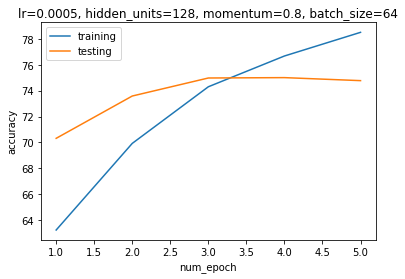

In [5]:
"""
Ting-Liang Huang
"""


from __future__ import division
from __future__ import print_function

import sys

try:
   import _pickle as pickle
except:
   import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# This is a class for a LinearTransform layer which takes an input 
# weight matrix W and computes W x as the forward step
class LinearTransform(object):

    def __init__(self, W, b):
        # DEFINE __init function:  W, b, momentum_parameter
        self.W = W
        self.b = b
        self.w_mom = 0
        self.b_mom = 0
    def forward(self, x):
        # DEFINE forward function
        # Calculate z = W.T*x + b
        self.x = x
        z = np.dot(self.x, self.W) + self.b
        return z
    
    def backward(
        self, 
        grad_output, 
        learning_rate, 
        mom, 
        l2_penalty=0,
    ):
        # DEFINE backward function
        # Update w and b
        dx = np.dot(grad_output, self.W.T)
        self.w_mom = mom * self.w_mom - learning_rate * np.dot(self.x.T, grad_output)
        self.b_mom = mom * self.b_mom - learning_rate * np.sum(grad_output, axis=0)
        self.W += self.w_mom
        self.b += self.b_mom
        return dx, self.W, self.b

# ADD other operations in LinearTransform if needed

# This is a class for a ReLU layer max(x,0)
class ReLU(object):
    
    def __init__(self):
        None
        
    def forward(self, x):
        # DEFINE forward function
        self.x = x
        self.output = (x * (x > 0))
        return self.output
    
    def backward(
        self, 
        grad_output, 
        learning_rate=None, 
        momentum=None, 
        l2_penalty=None,
    ):
        # DEFINE backward function
        # Derivative relu
        self.output[self.output > 0] = 1 
        out = grad_output * self.output
        return out

# ADD other operations in ReLU if needed

# This is a class for a sigmoid layer followed by a cross entropy layer, the reason 
# this is put into a single layer is because it has a simple gradient form
class SigmoidCrossEntropy(object):
    
    def __init__(self):
        None
        
    def forward(self, x):
        # DEFINE forward function
        self.sigmoid = 1.0 / (1.0 + np.exp(-x))
        return self.sigmoid
        
    def backward(
        self, 
        y,
        grad_output,
        learning_rate=0.0,
        momentum=0.0,
        l2_penalty=0.0
    ):
        # DEFINE backward function
        self.y = y
        d = grad_output * (self.sigmoid - self.y)
        return d
        
# This is a class for the Multilayer perceptron
class MLP(object):

    def __init__(self, input_dims, hidden_units):
        # INSERT CODE for initializing the network
        self.input_dims = input_dims
        self.hidden_units = hidden_units        
        self.w_1 = np.random.standard_normal((input_dims, hidden_units))
        self.b_1 = np.random.standard_normal((1, hidden_units))
        self.w_2 = np.random.standard_normal((hidden_units, 1))
        self.b_2 = np.random.standard_normal((1, 1))
        self.l1 = LinearTransform(self.w_1, self.b_1)
        self.l2 = LinearTransform(self.w_2, self.b_2)
        self.relu = ReLU()
        self.SCE = SigmoidCrossEntropy()
        self.y_pred = 0
        self.x_ = 0
        self.y_ = 0
        
    def train(
        self,
        x,
        y,
        batch_size,
        learning_rate,
        momentum,
        l2_penalty
    ):
        # INSERT CODE for training the network
        self.x_ = x[b * batch_size: (b + 1) * batch_size, :]
        self.y_ = y[b * batch_size: (b + 1) * batch_size, :]
        # Forward
        z_1 = self.l1.forward(self.x_)
        z_1_relu = self.relu.forward(z_1)
        z_2 = self.l2.forward(z_1_relu)
        z_2_SCE = self.SCE.forward(z_2)
        self.y_pred = np.round(z_2_SCE)
        # Backprop
        d_z = self.SCE.backward(self.y_, 1)
        dx_2, dw_2, db_2 = self.l2.backward(d_z, learning_rate, momentum)
        dx2_r = self.relu.backward(dx_2)
        dx_1, dw_1, db_1 = self.l1.backward(dx2_r, learning_rate, momentum)

    def Loss_function(self, l2_penalty):
        L = -1 * (self.y_ * np.log(self.y_pred + 10e-8) + (1.0 - self.y_) * np.log(1.0 - self.y_pred + 10e-8))
        L += l2_penalty / 2 * (np.sum(np.square(self.w_1)) + np.sum(np.square(self.w_2)))
        accuracy = 100 * np.mean((np.round(self.y_pred) == self.y_))
        avg_loss = np.mean(L)
        return accuracy, avg_loss

    def evaluate(self, x, y, batch_size, l2_penalty):
        # INSERT CODE for testing the network
        num_data = x.shape[0]
        num_b = round(num_data/batch_size)
        
        b_loss, b_acc = [], []
        # Make data into different batches.
        for b in range(num_b):
            x_ = x[b * b: (b + 1) * batch_size, :]
            y_ = y[b * b: (b + 1) * batch_size, :]

            # Forward 
            z_1 = self.l1.forward(x_)
            z_1_relu = self.relu.forward(z_1)
            z_2 = self.l2.forward(z_1_relu)
            z_2_SCE = self.SCE.forward(z_2)
            y_pred = np.round(z_2_SCE)

            # Calculate loss and accuracy
            L = -1 * (y_ * np.log(y_pred + 10e-8) + (1.0 - y_) * np.log(1.0 - y_pred + 10e-8))
            L += l2_penalty / 2 * (np.sum(np.square(self.w_1)) + np.sum(np.square(self.w_2)))
            accuracy = 100 * np.mean(y_pred == y_)
            avg_loss = np.mean(L)
            b_loss.append(avg_loss)
            b_acc.append(accuracy)

        return np.mean(b_loss), np.mean(b_acc)
    # ADD other operations and data entries in MLP if needed
# Function for normalization
def normalization(x):
    x_max = np.max(x, axis = 0)
    x_nor = x / x_max
    x_mean_train = np.mean(x_nor, axis = 0)
    x = (x_nor - x_mean_train)
    return x
    
if __name__ == '__main__':
    # Read data
    if sys.version_info[0] < 3:
        data = pickle.load(open('cifar_2class_py2.p', 'rb'))
    else:
        data = pickle.load(open('cifar_2class_py2.p', 'rb'), encoding='bytes')
    
    x_train_row = data[b'train_data']
    y_train = data[b'train_labels']
    x_test_row = data[b'test_data']
    y_test = data[b'test_labels']
    
    num_data, input_dims = x_train_row.shape
    # INSERT YOUR CODE HERE
    # Data Normalization
    x_train = normalization(x_train_row)
    x_test = normalization(x_test_row)

    # YOU CAN CHANGE num_epochs AND num_batches TO YOUR DESIRED VALUES
    # Parameters that can be change to test the efficiency of DNN
    
    print('-------------------------------best scenario-------------------------------')
    hidden_units = 128
    learning_rate = 0.005
    momentum = 0.8
    num_epochs = 5
    batch_size = 64
    l2_penalty = 0
    # Create DNN model
    model = MLP(input_dims, hidden_units)
    ttl_train_loss, ttl_train_acc, ttl_val_loss, ttl_val_acc = [], [], [], []
    for epoch in range(num_epochs):
        num_b = num_data // batch_size
    # INSERT YOUR CODE FOR EACH EPOCH HERE
        train_loss_set, train_acc_set = [], []
        for b in range(num_b):
            # Feed data to model and get training accuracy
            model.train(x_train, y_train, batch_size, learning_rate, momentum, l2_penalty)
            train_acc, train_loss = model.Loss_function(l2_penalty)
            train_loss_set.append(np.mean(train_loss))
            train_acc_set.append(np.mean(train_acc))
        ttl_train_loss.append(np.mean(train_loss_set))
        ttl_train_acc.append(np.mean(train_acc_set))
        # Feed the validation data to trained model and test accuracy
        val_loss, val_acc = model.evaluate(x_test, y_test, batch_size, l2_penalty)
        ttl_val_acc.append(val_acc)
        ttl_val_loss.append(val_loss)
        print("[Epoch {}/{}] train_loss: {:.3f}  train_accuracy: {:.3f}%  validation_loss: {:.3f}  validation_accuracy: {:.3f}%".format(epoch+1, num_epochs, np.mean(train_loss_set), np.mean(train_acc_set), np.mean(val_loss), np.mean(val_acc)))
    print("Best accuracy => train_accuracy: {:.3f}%  validation_accuracy: {:.3f}%".format(np.max(ttl_train_acc), np.max(ttl_val_acc)))
    a_axis = range(1,num_epochs+1)
    plt.plot(a_axis, ttl_train_acc)
    plt.plot(a_axis, ttl_val_acc)
    plt.xlabel('num_epoch')
    plt.ylabel('accuracy')
    plt.title('lr=0.0005, hidden_units=128, momentum=0.8, batch_size=64')
    plt.legend(['training', 'testing'])
    plt.savefig('best_scenario_plot.jpg')    
    '''
    print('---------------test accuracy with different number of batch size---------------')
    hidden_units = 256
    learning_rate = 0.0005
    momentum = 0.8
    num_epochs = 30
    batch_size = [64, 128, 256, 512]
    l2_penalty = 0
    # Create DNN model
    diff_batch_acc = []
    for size in batch_size:
        print('batch size = {}'.format(size))
        model = MLP(input_dims, hidden_units)
        ttl_train_loss, ttl_train_acc, ttl_val_loss, ttl_val_acc = [], [], [], []
        for epoch in range(num_epochs):
            num_b = num_data // size
        # INSERT YOUR CODE FOR EACH EPOCH HERE
            train_loss_set, train_acc_set = [], []
            for b in range(num_b):
                # Feed data to model and get training accuracy
                model.train(x_train, y_train, size, learning_rate, momentum, l2_penalty)
                train_acc, train_loss = model.Loss_function(l2_penalty)
                train_loss_set.append(np.mean(train_loss))
                train_acc_set.append(np.mean(train_acc))
            ttl_train_loss.append(np.mean(train_loss_set))
            ttl_train_acc.append(np.mean(train_acc_set))
            # Feed the validation data to trained model and test accuracy
            val_loss, val_acc = model.evaluate(x_test, y_test, size, l2_penalty)
            ttl_val_acc.append(val_acc)
            ttl_val_loss.append(val_loss)
            print("[Epoch {}/{}] train_loss: {:.3f}  train_accuracy: {:.3f}%  validation_loss: {:.3f}  validation_accuracy: {:.3f}%".format(epoch+1, num_epochs, np.mean(ttl_train_loss), np.mean(ttl_train_acc), np.mean(ttl_val_loss), np.mean(ttl_val_acc)))
        print("Best accuracy => train_accuracy: {:.3f}%  validation_accuracy: {:.3f}%".format(np.max(ttl_train_acc), np.max(ttl_val_acc)))
        diff_batch_acc.append(ttl_val_acc)
    a_axis = range(1,num_epochs+1)
    plt.plot(a_axis, diff_batch_acc[0])
    plt.plot(a_axis, diff_batch_acc[1])
    plt.plot(a_axis, diff_batch_acc[2])
    plt.plot(a_axis, diff_batch_acc[3])
    plt.xlabel('num_epoch')
    plt.ylabel('accuracy')
    plt.legend(['b_size=64','b_size=128', 'b_size=256','b_size=512'])
    plt.title('test accuracy with different number of batch size')
    plt.savefig('diff_num_b_size.jpg')        
    
    print('---------------test accuracy with different learning rate---------------')
    hidden_units = 256
    learning_rate = [0.05, 0.005, 0.0005, 0.00005]
    momentum = 0.8
    num_epochs = 10
    batch_size = 128
    l2_penalty = 0
    # Create DNN model
    diff_lr_acc = []
    for lr in learning_rate:
        print('learning rate = {}'.format(lr))
        model = MLP(input_dims, hidden_units)
        ttl_train_loss, ttl_train_acc, ttl_val_loss, ttl_val_acc = [], [], [], []
        for epoch in range(num_epochs):
            num_b = num_data // batch_size
        # INSERT YOUR CODE FOR EACH EPOCH HERE
            train_loss_set, train_acc_set = [], []
            for b in range(num_b):
                # Feed data to model and get training accuracy
                model.train(x_train, y_train, batch_size, lr, momentum, l2_penalty)
                train_acc, train_loss = model.Loss_function(l2_penalty)
                train_loss_set.append(np.mean(train_loss))
                train_acc_set.append(np.mean(train_acc))
            ttl_train_loss.append(np.mean(train_loss_set))
            ttl_train_acc.append(np.mean(train_acc_set))
            # Feed the validation data to trained model and test accuracy
            val_loss, val_acc = model.evaluate(x_test, y_test, batch_size, l2_penalty)
            ttl_val_acc.append(val_acc)
            ttl_val_loss.append(val_loss)
            print("[Epoch {}/{}] train_loss: {:.3f}  train_accuracy: {:.3f}%  validation_loss: {:.3f}  validation_accuracy: {:.3f}%".format(epoch+1, num_epochs, np.mean(ttl_train_loss), np.mean(ttl_train_acc), np.mean(ttl_val_loss), np.mean(ttl_val_acc)))
        print("Best accuracy => train_accuracy: {:.3f}%  validation_accuracy: {:.3f}%".format(np.max(ttl_train_acc), np.max(ttl_val_acc)))
        diff_lr_acc.append(ttl_val_acc)
    a_axis = range(1,num_epochs+1)
    plt.plot(a_axis, diff_lr_acc[0])
    plt.plot(a_axis, diff_lr_acc[1])
    plt.plot(a_axis, diff_lr_acc[2])
    plt.plot(a_axis, diff_lr_acc[3])
    plt.xlabel('num_epoch')
    plt.ylabel('accuracy')
    plt.legend(['0.0005', '0.00005', '0.000005', '0.0000005'])
    plt.title('test accuracy with different learning rate')
    plt.savefig('diff_lr.jpg')         
    
    print('---------------test accuracy with different number of hidden units---------------')    
    hidden_units = [64,128,256,512,1024]
    learning_rate = 0.0005
    momentum = 0.8
    num_epochs = 10
    batch_size = 64
    l2_penalty = 0
    # Create DNN model
    diff_h_u = []
    for u in hidden_units:
        print('hidden_units = {}'.format(u))
        model = MLP(input_dims, u)
        ttl_train_loss, ttl_train_acc, ttl_val_loss, ttl_val_acc = [], [], [], []
        for epoch in range(num_epochs):
            num_b = num_data // batch_size
        # INSERT YOUR CODE FOR EACH EPOCH HERE
            train_loss_set, train_acc_set = [], []
            for b in range(num_b):
                # Feed data to model and get training accuracy
                model.train(x_train, y_train, batch_size, learning_rate, momentum, l2_penalty)
                train_acc, train_loss = model.Loss_function(l2_penalty)
                train_loss_set.append(np.mean(train_loss))
                train_acc_set.append(np.mean(train_acc))
            ttl_train_loss.append(np.mean(train_loss_set))
            ttl_train_acc.append(np.mean(train_acc_set))
            # Feed the validation data to trained model and test accuracy
            val_loss, val_acc = model.evaluate(x_test, y_test, batch_size, l2_penalty)
            ttl_val_acc.append(val_acc)
            ttl_val_loss.append(val_loss)
            print("[Epoch {}/{}] train_loss: {:.3f}  train_accuracy: {:.3f}%  validation_loss: {:.3f}  validation_accuracy: {:.3f}%".format(epoch+1, num_epochs, np.mean(train_loss_set), np.mean(train_acc_set), np.mean(val_loss), np.mean(val_acc)))
        print("Best accuracy => train_accuracy: {:.3f}%  validation_accuracy: {:.3f}%".format(np.max(ttl_train_acc), np.max(ttl_val_acc)))
        diff_h_u.append(ttl_val_acc)
    a_axis = range(1,num_epochs+1)
    plt.plot(a_axis, diff_h_u[0])
    plt.plot(a_axis, diff_h_u[1])
    plt.plot(a_axis, diff_h_u[2])
    plt.plot(a_axis, diff_h_u[3])
    plt.plot(a_axis, diff_h_u[4])
    plt.xlabel('num_epoch')
    plt.ylabel('accuracy')
    plt.title('test accuracy with different number of hidden units')
    plt.legend(['64','128','256','512','1024'])
    plt.savefig('diff_hidden_units.jpg')        
    '''
        
        